In [37]:
#This first chunk just imports some modules we will be using
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import random
import pandas as pd
from subprocess import check_output
##This sets addresses for the training and test datasets.
## If you are running this on your own machine, you'll need to place the fashion-mnist_train and fashion-mnist_test
## csv files into the same directory as this file and change the dirrectory path below.





In [38]:
## We need to import the files into 

df = pd.read_csv('chinese_mnist.csv')

In [39]:
print(df.head())


   suite_id  sample_id  code  value character
0         1          1    10      9         九
1         1         10    10      9         九
2         1          2    10      9         九
3         1          3    10      9         九
4         1          4    10      9         九


Okay, this is just the labeling of the data -- the actual images are stored in another folder called 'Data.'

The first (unlabeled) column is an id column. 

The second one labels the "suite" -- basically which person was drawing the characters. Each of the 100 volunteers created 10 samples, and each sample contains 15 characters ("codes"), so we should have 15000 rows. 

The last two columns contain the numerical value of the character (1-10, then the next 5 powers of 10) and the character itself. We will use the value column quite a bit as a label. 



There's something a little annoying about the data frame: the "finest" part of the counter (code) is not moving the fastest. 


In [40]:
def reindex(suite_id, sample_id, code):
    index = 150*(suite_id-1)+ 15*(sample_id-1) + code
    return index-1
    
print(reindex(1,10,9))

143


In [41]:


df['index'] = df.apply(lambda x: reindex(x.suite_id,x.sample_id,x.code),axis=1)


In [42]:
print(df.shape)

(15000, 6)


In [43]:
print(df.head(20))

    suite_id  sample_id  code  value character  index
0          1          1    10      9         九      9
1          1         10    10      9         九    144
2          1          2    10      9         九     24
3          1          3    10      9         九     39
4          1          4    10      9         九     54
5          1          5    10      9         九     69
6          1          6    10      9         九     84
7          1          7    10      9         九     99
8          1          8    10      9         九    114
9          1          9    10      9         九    129
10        10          1    10      9         九   1359
11        10         10    10      9         九   1494
12        10          2    10      9         九   1374
13        10          3    10      9         九   1389
14        10          4    10      9         九   1404
15        10          5    10      9         九   1419
16        10          6    10      9         九   1434
17        10          7    1

In [44]:
df = df.sort_values(by='index')

In [45]:
print(df.head(20))

       suite_id  sample_id  code      value character  index
6000          1          1     1          0         零      0
7000          1          1     2          1         一      1
8000          1          1     3          2         二      2
9000          1          1     4          3         三      3
10000         1          1     5          4         四      4
11000         1          1     6          5         五      5
12000         1          1     7          6         六      6
13000         1          1     8          7         七      7
14000         1          1     9          8         八      8
0             1          1    10          9         九      9
1000          1          1    11         10         十     10
2000          1          1    12        100         百     11
3000          1          1    13       1000         千     12
4000          1          1    14      10000         万     13
5000          1          1    15  100000000         亿     14
6002          1         

In [46]:
df = df.set_index('index')

In [47]:
print(df.head())

       suite_id  sample_id  code  value character
index                                            
0             1          1     1      0         零
1             1          1     2      1         一
2             1          1     3      2         二
3             1          1     4      3         三
4             1          1     5      4         四


The important thing for us is the value of each row (we do not expect suite_id, sample_id, or code to have meaning for an image classification task, and character is redundant with value). Now we actually need the training features, and we have to get all the images wrangled into the dataframe.

In [48]:
images = []

for i in range(1,101):
    for j in range(1,11):
        for k in range(1,16):
            index  = reindex(i,j,k)
            filename = '_'.join([str(i),str(j),str(k)])
            filename = 'input_'+filename + '.jpg'
            path = 'data/'+filename
            img = mpimg.imread(path).flatten()
            images += [img]




In [49]:
features = np.array(images)

In [50]:
type(images)

list

In [51]:
df['image'] = images

This is great, now we have a properly indexed dataframe. Let's check to make sure the actual images line up with the data. We pick a random entry from the character column, and note that the image does seem to match the character stored in the character column :). 

In [52]:
num = random.randrange(0,15000)

print(df['character'][num])

五


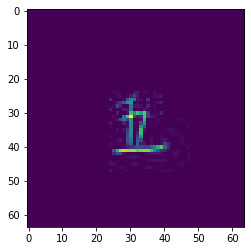

In [53]:
image = df['image'][num]
reshaped_image = np.reshape(image, (64, 64))
plt.imshow(reshaped_image)

Now that we know the characters and the images line up correctly, we can discard those columns.

In [54]:
df = df.drop(columns = ['suite_id','sample_id','code','character'])
print(df.head(10))

       value                                              image
index                                                          
0          0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1          1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2          2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3          3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4          4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5          5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6          6  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7          7  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
8          8  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
9          9  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...


Now we have a pretty useful form for the datframe: an index column, a label column ('value') and a feature column ('image'). We scale the image values so that they are all between 0 and 1.

In [55]:
features = features/255

Unfortunately, numpy arrays don't allow string inputs, and we don't want a one hundred million-vector to represent fifteen possible values. So we will code the values as 100 = 11, 1000 = 12, 10000 = 13, 

In [56]:
def number_changer(num):
    if num > 10000:
        num = 14
    elif num > 1000:
        num = 13
    elif num > 100: 
        num = 12
    elif num > 10:
        num = 11
    return num

In [57]:
df['changed_value'] = df.apply(lambda x: number_changer(x.value), axis=1)



In [58]:
labels = df['changed_value']
labels = labels.to_numpy()

In [59]:
for t in range(30):
    print(labels[t])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


We peel the values off the dataframe into a numpy array, the preferred input for fitting a keras model. 

In [60]:
labels = tf.keras.utils.to_categorical(labels)

In [61]:
len(labels[0])

15

Now we split up the data into training and test sets. We could do this "by hand" if we wanted to, but it's nice to let sklearns's split package do the work.

In [62]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels)



The commands below cast the 15 possible labels in a one-to-hot encoding (example: if the label is 4, then it becomes a vector of length 15 with 0's everywhere except in the fourth position, where the value is 1). 

In [63]:
#This specifies the size of the model for us 
#(it is still "empty" as it has not been compiled or trained)
# Think of this as the blueprint for the model before it has been built
# Each Dense layer is fully connected to the previous layer
# The integer argument specifies the number of nodes
# The activation is set to Rectified Linear Unit = (0.5)*(x+|x|)
# Which is the standard activation for each node, 
# replacing the earlier standards of sigmoid and hyperbolic tangent.

model  = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(30,activation=tf.nn.relu,input_shape=(4096,)))
model.add(tf.keras.layers.Dense(20,activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(15,activation=tf.nn.softmax))

## Now we "compile" the model -- we actually build it!

# We also specify a loss function (this is what the NN will try
# to minimize during training), an optimizer (this is the 
# method by which the NN tries to minimize the loss),
# and a metric (this is the metric by which we judge the performance
# of the algorithm at its assigned task -- in this case classification)
# The difference between loss and non-accuracy is a little subtle
# Basically the job of the loss function is to be something that is 
# easy to calculate and optimize, and hopefully by minimizing loss
# we get something that maximizes accuracy. 

# Think of this as putting in the wiring and plumbing and light fixtures

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])


#note that the metrics argument is a list, because we can ask the 
#NN to calculate as many metrics as we like. We can only specify a single
# loss function and optimizer though (although you could probably 
#stitch together several loss functions using a max or sum). 

model.summary()

#after we print the model summary we see that there are 23550=785*30 
# = 28*28*30 + 30
#parameters for the first layer. Each of the 28*28*30 corresponds to 
# one pixel being added to one of the nodes in the first layer,
#whereas the others are weights (I think) for the 30 nodes

#Likewise we get 620 = 30*20 + 20 params for the second layer, the
# 30*20 corresponding to the connections between nodes in the first 
#and second layers and the 20 corresponding to weights on the
#second layer nodes themselves. And the pattern continues in the third 
#layer. IF we had chosen a non-Dense layer, then not every node 
#would connect to every node in the adjacent layers, and we 
#would have fewer parameters (probably there is some reason to try this)

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_252 (Dense)            (None, 30)                122910    
_________________________________________________________________
dense_253 (Dense)            (None, 20)                620       
_________________________________________________________________
dense_254 (Dense)            (None, 15)                315       
Total params: 123,845
Trainable params: 123,845
Non-trainable params: 0
_________________________________________________________________


In [64]:

## This just specifies how often we feed the training data into the network (epochs is roughly the number 
## of iterations and batch is the amount of data fed each time). 

epochs_no = 10
batch_no = 40



The command below fits the neural network to the training data. 

In [65]:
model.fit(train_features,train_labels,epochs=epochs_no,batch_size=batch_no)

Epoch 1/10
282/282 [==============================] - 0s 986us/step - loss: 2.3229 - accuracy: 0.2540
Epoch 2/10
282/282 [==============================] - 0s 873us/step - loss: 1.7893 - accuracy: 0.4804
Epoch 3/10
282/282 [==============================] - 0s 917us/step - loss: 1.4827 - accuracy: 0.5644
Epoch 4/10
282/282 [==============================] - 0s 946us/step - loss: 1.2696 - accuracy: 0.6240
Epoch 5/10
282/282 [==============================] - 0s 961us/step - loss: 1.1145 - accuracy: 0.6654
Epoch 6/10
282/282 [==============================] - 0s 971us/step - loss: 0.9961 - accuracy: 0.7002
Epoch 7/10
282/282 [==============================] - 0s 891us/step - loss: 0.8985 - accuracy: 0.7270
Epoch 8/10
282/282 [==============================] - 0s 936us/step - loss: 0.8185 - accuracy: 0.7487
Epoch 9/10
282/282 [==============================] - 0s 888us/step - loss: 0.7464 - accuracy: 0.7688
Epoch 10/10
282/282 [==============================] - 0s 845us/step - loss: 0.686

In [66]:
## The test accuracy

In [67]:
test_loss,test_acc = model.evaluate(test_features,test_labels)
print("Test accuracy is ",test_acc)

118/118 [==============================] - 0s 515us/step - loss: 1.0544 - accuracy: 0.6667
Test accuracy is  0.6666666865348816


We see that the test accuracy is considerably worse than the training accuracy -- this indicates severe 
overfitting. Let's try to find the "sweet spot" where we minimize bias+variance. For now we'll just tinker with the number of epochs.  

In [71]:
epoch_values = [t+1 for t in range(6,12)]

test_accuracy = []

for num in epoch_values:
    epochs_no = num
    model  = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(30,activation=tf.nn.relu,input_shape=(4096,)))
    model.add(tf.keras.layers.Dense(20,activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(15,activation=tf.nn.softmax))
    model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])
    batch_no = 10
    model.fit(train_features,train_labels,epochs=epochs_no,batch_size=batch_no)
    test_loss,test_acc = model.evaluate(test_features,test_labels)
    test_accuracy.append([test_loss,test_acc])

    

Epoch 1/7
1125/1125 [==============================] - 1s 704us/step - loss: 2.1354 - accuracy: 0.3403
Epoch 2/7
1125/1125 [==============================] - 1s 657us/step - loss: 1.4958 - accuracy: 0.5544
Epoch 3/7
1125/1125 [==============================] - 1s 651us/step - loss: 1.1785 - accuracy: 0.6396
Epoch 4/7
1125/1125 [==============================] - 1s 657us/step - loss: 0.9777 - accuracy: 0.7040
Epoch 5/7
1125/1125 [==============================] - 1s 658us/step - loss: 0.8399 - accuracy: 0.7435
Epoch 6/7
1125/1125 [==============================] - 1s 660us/step - loss: 0.7368 - accuracy: 0.7728
Epoch 7/7
118/118 [==============================] - 0s 518us/step - loss: 0.9760 - accuracy: 0.7016
Epoch 1/8
1125/1125 [==============================] - 1s 695us/step - loss: 2.0954 - accuracy: 0.3480
Epoch 2/8
1125/1125 [==============================] - 1s 716us/step - loss: 1.5058 - accuracy: 0.5441
Epoch 3/8
1125/1125 [==============================] - 1s 705us/step - loss

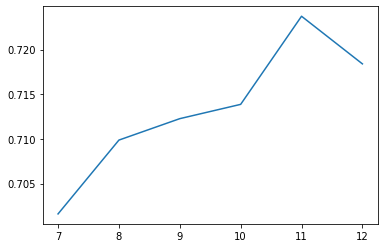

In [72]:
accuracies = [y for [x,y] in test_accuracy]
plt.plot(epoch_values,accuracies)


Looks like the best performance is somewhere around 11 epochs. 

In [73]:
lst = [epoch_values, accuracies]

test_df = pd.DataFrame(list(zip(epoch_values, accuracies)), 
               columns =['Epochs', 'Accuracy']) 